# Demo
## Vortex dynamics

In this example, we are going to simulate vortex core dynamics. After creating a vortex structure, we are first going to displace it by applying an external magnetic field. We will then turn off the external field, and compute the time-development of the system, and then be able to see the dynamics of the vortex core.

The sample is a two-dimensional Permalloy square sample with $d=100 \,\text{nm}$ edge length and $5\,\text{nm}$ thickness. Its energy equation consists of ferromagnetic exchange, Zeeman, and demagnetisation energy terms:
    
$$E = \int_{V} \left[-A\mathbf{m}\cdot\nabla^{2}\mathbf{m} - \mu_{0}M_\text{s}\mathbf{m}\cdot\mathbf{H} + w_\text{d}\right] \text{d}V,$$

where $A = 13 \,\text{pJ}\,\text{m}^{-1}$ is the exchange energy constant, $M_\text{s} = 8 \times 10^{5} \,\text{A}\,\text{m}^{-1}$ magnetisation saturation, $w_\text{d}$ demagnetisation energy density, $\mathbf{H}$ an external magnetic field, and $\mathbf{m}=\mathbf{M}/M_\text{s}$ the normalised magnetisation field.

The magnetisation dynamics is governed by the Landau-Lifshitz-Gilbert equation consisting of precession and damping terms:

$$\frac{\partial\mathbf{m}}{\partial t} = -\frac{\gamma_{0}}{1+\alpha^{2}}\mathbf{m}\times\mathbf{H}_\text{eff} - \frac{\gamma_{0}\alpha}{1+\alpha^{2}}\mathbf{m}\times(\mathbf{m}\times\mathbf{H}_\text{eff}),$$

where $\gamma_{0} = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$ and $\alpha = 0.2$ is the Gilbert damping.

The (initial) magnetisation field is a vortex state, whose magnetisation at each point $(x, y, z)$ in the sample can be represented as $(m_{x}, m_{y}, m_{z}) = (-cy, cx, 0.1)$, with $c = 10^{9} \text{m}^{-1}$.

In [1]:
# Some initial configurations
#%config InlineBackend.figure_formats = ['svg']  # output matplotlib plots as SVG
import pandas as pd
pd.options.display.max_rows = 5
pd.options.display.float_format = '{:,.2e}'.format

## System initialisation

The Ubermag code for defining the micromagnetic system is:

In [2]:
import discretisedfield as df
import micromagneticmodel as mm

# Geometry
L = 100e-9  # sample edge length (m)
thickness = 5e-9  # sample thickness (m)

# Material (Permalloy) parameters
Ms = 8e5  # saturation magnetisation (A/m)
A = 13e-12  # exchange energy constant (J/m)

# Dynamics (LLG equation) parameters
gamma0 = mm.consts.gamma0  # gyromagnetic ratio (m/As)
alpha = 0.2  # Gilbert damping

system = mm.System(name='vortex_dynamics')

# Energy equation. We omit Zeeman energy term, because H=0.
system.energy = mm.Exchange(A=A) + mm.Demag()

# Dynamics equation
system.dynamics = mm.Precession(gamma0=gamma0) + mm.Damping(alpha=alpha)

# initial magnetisation state
def m_init(point):
    x, y, z = point
    c = 1e9  # (1/m)
    return (-c*y, c*x, 0.1)

# Sample's centre is placed at origin
region = df.Region(p1=(-L/2, -L/2, -thickness/2), p2=(L/2, L/2, thickness/2))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system.m = df.Field(mesh, dim=3, value=m_init, norm=Ms)

The system object is now defined and we can investigate some of its properties:

In [3]:
system.energy

Exchange(A=1.3e-11) + Demag()

In [4]:
system.dynamics

Precession(gamma0=221276.14872118403) + Damping(alpha=0.2)

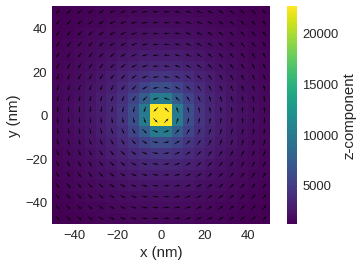

In [5]:
system.m.plane('z').mpl()

## Energy minimisation
To carry out micromagnetic simulation, we need to use a micromagnetic calulator. We are going to use OOMMF for this.
We can now relax the system in the absence of external magnetic field using energy minimisation driver (`MinDriver`):

Running OOMMF (ExeOOMMFRunner)[2022/05/22 11:46]... (0.4 s)


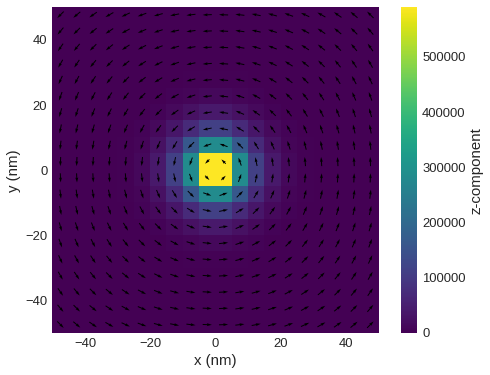

In [6]:
import oommfc as mc  # Micromagnetic Calculator

md = mc.MinDriver()
md.drive(system)

system.m.plane('z').mpl()

## Displacement with magnetic field

Now, we have a relaxed vortex state, with its core at the centre of the sample. As the next step, we want to add an external magnetic field $H=10^{4}\,\text{Am}^{-1}$ in the positive $x$-direction to displace the vortex core. We do that by adding the Zeeman energy term to the energy equation:

Running OOMMF (ExeOOMMFRunner)[2022/05/22 11:46]... (0.3 s)


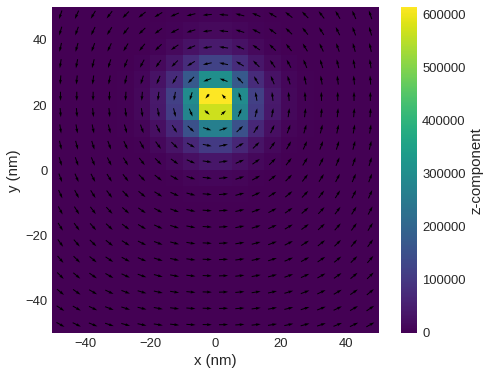

In [7]:
H = (1e4, 0, 0)  # an external magnetic field (A/m)

system.energy += mm.Zeeman(H=H)

md.drive(system)
system.m.plane('z').mpl()

## Free relaxation

The vortex core is now displaced in the positive $y$-direction. As the last step, we are going to turn off the external magnetic field and simulate dynamics using `TimeDriver`. We are going to run simulation for $5\,\text{ns}$ and save the magnetisation in $500$ steps.

In [8]:
system.energy.zeeman.H = (0, 0, 0)

td = mc.TimeDriver()
td.drive(system, t=5e-9, n=500, verbose=2)

Running OOMMF (ExeOOMMFRunner):   0%|          | 0/500 files written [00:00]

The final magnetisation state shows that the vortex core has moved back to the sample's centre.

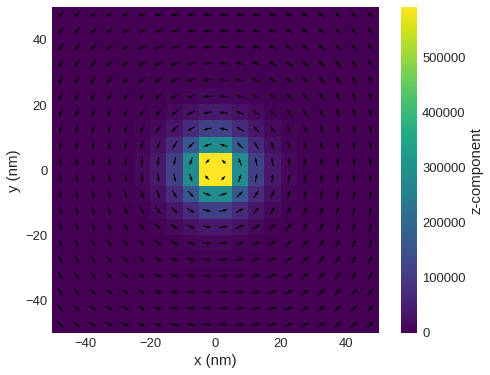

In [9]:
system.m.plane('z').mpl()

We can also visualise $M_{z}$ using an interactive three-dimensional plot.

In [10]:
system.m.z.k3d.scalar()

Output()

## Data analysis
The table with scalar data saved during the simulation. Each row corresponds to one of the 500 saved configurations. We only show selected columns.

In [11]:
system.table.data[['t', 'mx', 'my', 'mz', 'E']]

,t,mx,my,mz,E
0,1.00e-11,3.52e-01,7.35e-04,2.32e-02,1.85e-18
1,2.00e-11,3.36e-01,2.52e-03,2.31e-02,1.85e-18
...,...,...,...,...,...
498,4.99e-09,9.90e-06,-2.33e-04,2.29e-02,1.77e-18
499,5.00e-09,2.83e-05,-2.26e-04,2.29e-02,1.77e-18


We can now plot the average $m_{x}$ and $m_{y}$ values as taken from the table as a function of time to give us an idea of the vortex core position.

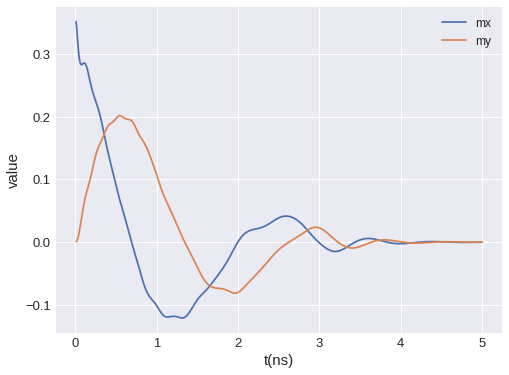

In [12]:
system.table.mpl(y=['mx', 'my'])

Finally, we are going to have a look at the magnetisation field at different time-steps using `micromagneticdata`.

In [13]:
import micromagneticdata as md

data = md.Data(system.name)
data.info

,drive_number,date,time,driver,t,n
0,0,2022-05-22,11:46:06,MinDriver,NaN,NaN
1,1,2022-05-22,11:46:06,MinDriver,NaN,NaN
2,2,2022-05-22,11:46:07,TimeDriver,5.00e-09,5.00e+02


To interactively inspect the time dependent magnetisation, we use `data[-1]` to refer to the last drive.

In [14]:
@df.interact(nstep=data[-1].slider())
def interactive_plot(nstep):
    data[-1][nstep].orientation.plane('z').mpl()

interactive(children=(IntSlider(value=0, description='step', max=499), Output()), _dom_classes=('widget-intera…

We can now compute winding number using operators from `discretisedfield`:

$$S = \frac{1}{4\pi}\iint q \,\,\text{d}x\text{d}y = \frac{1}{4\pi}\iint\mathbf{m}\cdot\left(\frac{\partial \mathbf{m}}{\partial x} \times \frac{\partial \mathbf{m}}{\partial y~}\right)\text{d}x\text{d}y$$

In [15]:
import math

m = system.m.orientation.plane('z')
q = m @ (m.derivative('x') & m.derivative('y'))
S = 1/(4*math.pi) * df.integral(q * df.dx*df.dy)
S

0.40036933483190135

The winging number is commonly used and there is a predefined function in `discretisedfield.tools`. To get more accurate results we use a different numerical method than just "naively" evaluating the integral.

In [16]:
import discretisedfield.tools as dft
dft.topological_charge(system.m.plane('z'), method='berg-luescher')

0.5005803208541975

Finally, let us delete all simulation files:

In [17]:
mc.delete(system)